# Nighttime Lights Exploratory Data Analysis

This notebook contains the exploratory data analysis of the nighttime lights 2016 dataset and generates CSV files required for splitting the images into training and validation datasets. 

After running the contents of this notebook and generating the necessary files, you may download the GSM images using the script: `src/data_download.py`.

## Imports and Setup

In [1]:
import sys
sys.path.insert(0, '../utils')
import warnings
warnings.filterwarnings('ignore')

import os
import time
import copy
import re

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import data_utils

SEED = 42
np.random.seed(SEED)

%matplotlib inline
TM_pal_categorical_3 = ('#ef4631', '#10b9ce', '#ff9138')
sns.set(style='white', font_scale=1, palette=TM_pal_categorical_3)

%load_ext autoreload
%autoreload 2

## File Locations

In [2]:
# Input data file paths
data_path = '../data/'
nightlights_file = data_path + 'nightlights.csv'
dhs_indicators_file = data_path + 'dhs_indicators.csv'

# Output data file paths 
nightlights_unstacked_file = data_path + 'nightlights_unstacked.csv'
nightlights_bins_file = data_path + 'nightlights_bins.csv'
nightlights_train_file = data_path + 'nightlights_train.csv'
nightlights_train_bal_file = data_path + 'nightlights_train_bal.csv' #balanced training set
nightlights_val_file = data_path + 'nightlights_val.csv'

## Night Time Lights Dataset EDA

### Load Nighttime Lights Dataset

In [3]:
nightlights = pd.read_csv(nightlights_file)
print('Number of images to download: {} \n'.format(nightlights.ID.nunique()))
nightlights.tail(3)

Number of images to download: 134540 



,ID,DHSCLUST,ntllon,ntllat,ntl2016,pop_sum
134537,323239,PH201700000726,122.683334,12.341666,0.00000,483.555064
134538,323240,PH201700000726,122.687501,12.362499,0.17369,141.463403
134539,323241,PH201700000726,122.687501,12.358333,0.11054,443.106126


### Sanity check number of pixels by nighttime light intensity

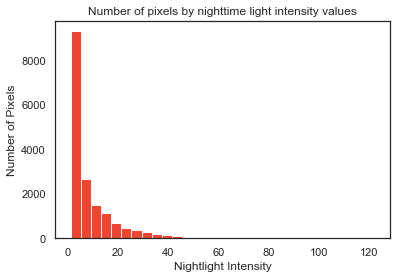

In [4]:
data_utils.plot_hist(
    nightlights[nightlights['ntl2016'] > 1]['ntl2016'],
    title='Number of pixels by nighttime light intensity values', 
    x_label='Nightlight Intensity', 
    y_label='Number of Pixels'
)

### Unstack Nighttime Lights Dataset
Unstack dataset so that each row consists of a unique (cluster, lat, lon) tuple.

In [5]:
nightlights = data_utils.unstack_clusters(nightlights)
nightlights.to_csv(nightlights_unstacked_file)
print("Total number of pixels (including duplicates belonging to different clusters): {}".format(len(nightlights)))

100%|██████████| 134540/134540 [00:54<00:00, 2447.03it/s]


Total number of pixels (including duplicates belonging to different clusters): 173580


### Sanity Check DHS Clusters and Nighttime Lights Summary Statistics

In [6]:
print("Number of unique clusters in night lights dataset: ", nightlights['DHSCLUST'].nunique())
nightlights['ntl2016'].describe()

Number of unique clusters in night lights dataset:  1214


count    173580.000000
mean          2.055890
std           7.030332
min           0.000000
25%           0.000000
50%           0.000000
75%           0.324230
max         122.432310
Name: ntl2016, dtype: float64

### Sanity Check Number of Pixels/Images Per Cluster

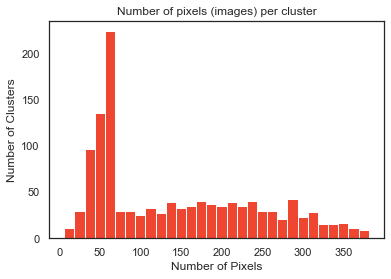

In [7]:
data_utils.plot_hist(
    nightlights.groupby('DHSCLUST').count()['ntl2016'],
    title='Number of pixels (images) per cluster', 
    x_label='Number of Pixels', 
    y_label='Number of Clusters'
)

### Sanity Check Proportion of Zero Intensity Levels in the Dataset

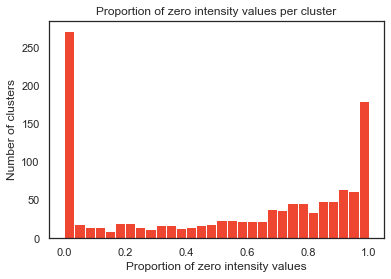

Around 150 clusters have ~100% zero night light intensity values (total darkness).
Percent of zero intensity pixels in dataset: 66%


In [8]:
nightlights_zero = nightlights.groupby(['DHSCLUST', 'ntl2016']).size().unstack(fill_value=0)
data_utils.plot_hist(
    nightlights_zero[0.0]/nightlights_zero.sum(axis=1),
    title='Proportion of zero intensity values per cluster', 
    x_label='Proportion of zero intensity values', 
    y_label='Number of clusters'
)
print("Around 150 clusters have ~100% zero night light intensity values (total darkness).")
percent_zeros = nightlights[nightlights['ntl2016'] == 0].shape[0]/len(nightlights)
print("Percent of zero intensity pixels in dataset: {:.0f}%".format(percent_zeros*100))

### Sanity Check Average Nighttime Lights Per Cluster

Shape of average night lights dataframe:  (1214, 2)


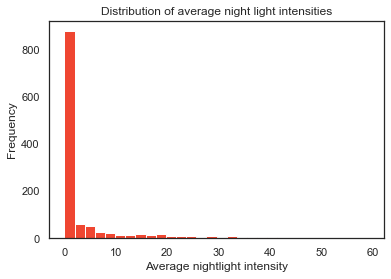

In [12]:
nightlights_avg = pd.DataFrame(nightlights.groupby(['DHSCLUST'])['ntl2016'].mean()).reset_index()
print("Shape of average night lights dataframe: ", nightlights_avg.shape)
data_utils.plot_hist(
    nightlights_avg['ntl2016'],
    title='Distribution of average night light intensities', 
    x_label='Average nightlight intensity', 
    y_label='Frequency'
)

### Get Sum of Population Per Cluster

Shape of population dataframe:  (1214, 2)


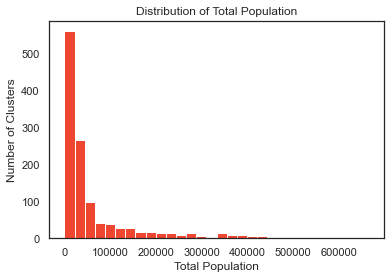

In [13]:
pop_sum = pd.DataFrame(nightlights.groupby(['DHSCLUST'])['pop_sum'].sum()).reset_index()
print("Shape of population dataframe: ", pop_sum.shape)
data_utils.plot_hist(
    pop_sum['pop_sum'],
    title='Distribution of Total Population', 
    x_label='Total Population', 
    y_label='Number of Clusters'
)

## Demographic and Health Survey (DHS) Dataset EDA

### Load DHS indicators 
Load DHS dataste and merge with average night time lights data.

In [14]:
dhs_indicators = pd.read_csv(dhs_indicators_file)
dhs_indicators.head(2)
nightlights_avg = nightlights_avg.merge(dhs_indicators, left_on='DHSCLUST', right_on='Cluster number')
pop_sum = pop_sum.merge(dhs_indicators, left_on='DHSCLUST', right_on='Cluster number')

print("Number of unique clusters in DHS data merged with NTL data: ", nightlights_avg['DHSCLUST'].nunique())
print("Number of unique clusters in DHS data merged with pop data: ", pop_sum['DHSCLUST'].nunique())

Number of unique clusters in DHS data merged with NTL data:  1213
Number of unique clusters in DHS data merged with pop data:  1213


### Correlations bet. Average NTL Intensity and Socioeconomic Indicators

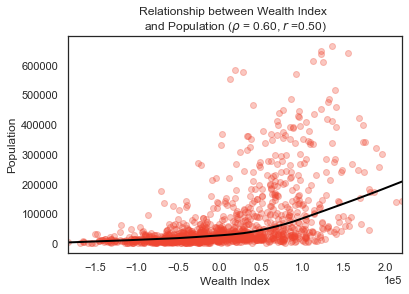

In [15]:
data_utils.plot_regplot(pop_sum, 'Wealth Index', 'Population', 'pop_sum')

In [18]:
data_utils

<module 'data_utils' from '../utils/data_utils.py'>

In [23]:
nightlights_avg.columns

Index(['DHSCLUST', 'ntl2016', 'Cluster number', 'Wealth Index',
       'Education completed (years)', 'Access to electricity',
       'Access to water (minutes)'],
      dtype='object')

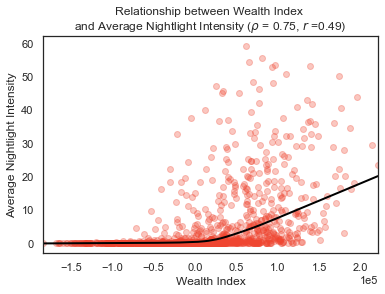

In [20]:
data_utils.plot_regplot(nightlights_avg, 'Wealth Index')

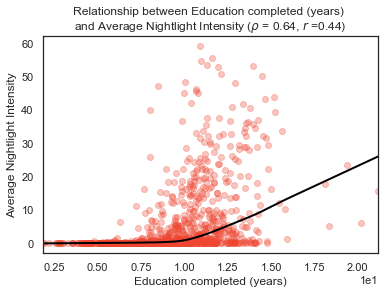

In [21]:
data_utils.plot_regplot(nightlights_avg, 'Education completed (years)')

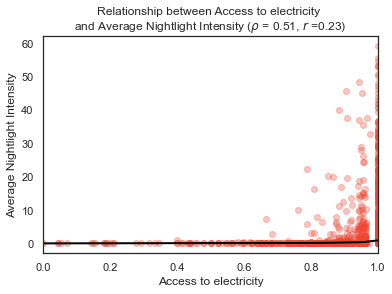

In [22]:
data_utils.plot_regplot(nightlights_avg, 'Access to electricity')

ValueError: array must not contain infs or NaNs

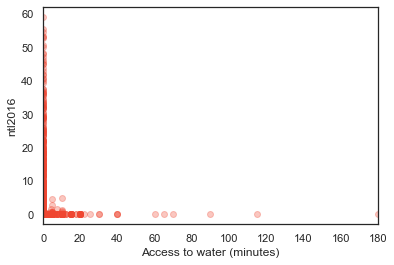

In [25]:
data_utils.plot_regplot(nightlights_avg, 'Access to water (minutes)')

## Binning Nighttime Light Intensities

###  Load Nighttime Lights Dataset

In [26]:
nightlights = pd.read_csv(nightlights_file)
nightlights.head(3)

,ID,DHSCLUST,ntllon,ntllat,ntl2016,pop_sum
0,0,"PH201700000387, PH201700000395",120.554167,18.212500,0.49878,446.725863
1,3,"PH201700000395, PH201700000387",120.554167,18.200000,0.29817,16.787817
2,4,"PH201700000387, PH201700000395",120.554167,18.195833,0.63710,151.090350


### Gaussian Mixture Model

In [27]:
bin_labels = ['low', 'low medium', 'medium', 'high medium', 'high']
nightlights = data_utils.gaussian_mixture_model(nightlights, n_components=5, bin_labels=bin_labels)
for label in bin_labels:
    print(
        "Number of {} intensity pixels: {}".format(
            label, nightlights[nightlights['label'] == label]['ntl2016'].count()
        )
    )

{0: 0.0, 1: 9.16312, 2: 0.4707, 3: 122.43231000000002, 4: 1.83839}
{0: 'low', 2: 'low medium', 4: 'medium', 1: 'high medium', 3: 'high'}
Number of low intensity pixels: 94680
Number of low medium intensity pixels: 16169
Number of medium intensity pixels: 10785
Number of high medium intensity pixels: 7844
Number of high intensity pixels: 5062


### Ad Hoc Label Assignment

In [28]:
bin_caps = [0, 2, 15, 30]
bin_labels = ['low', 'low medium', 'medium', 'high medium', 'high']
nightlights['label'] = nightlights['ntl2016'].apply(lambda x: data_utils.ad_hoc_binning(x, bin_caps, bin_labels))
print(nightlights[nightlights['label'] == 'high medium']['ntl2016'].describe())
for label in bin_labels:
    print(
        "Number of {} intensity pixels: {}".format(
            label, nightlights[nightlights['label'] == label]['ntl2016'].count()
        )
    )

count    2161.000000
mean       20.726912
std         4.231244
min        15.009130
25%        17.022590
50%        19.820690
75%        23.909240
max        29.994180
Name: ntl2016, dtype: float64
Number of low intensity pixels: 94680
Number of low medium intensity pixels: 27415
Number of medium intensity pixels: 9389
Number of high medium intensity pixels: 2161
Number of high intensity pixels: 895


### Save Binned Dataset

In [29]:
nightlights.to_csv(nightlights_bins_file, index=False)

print('Total number of images: ', nightlights.shape[0])
print(nightlights['label'].value_counts())
print(nightlights['label'].value_counts()/nightlights.shape[0])

Total number of images:  134540
low            94680
low medium     27415
medium          9389
high medium     2161
high             895
Name: label, dtype: int64
low            0.703731
low medium     0.203768
medium         0.069786
high medium    0.016062
high           0.006652
Name: label, dtype: float64


## Balancing Nighttime Lights Intensity Levels

### Load Nighttime Lights Dataset

In [30]:
nightlights = pd.read_csv(nightlights_bins_file)
print('Total number images downloaded: ', len(nightlights))

Total number images downloaded:  134540


### Shuffle NTL Dataset and Split into Train/Val Sets

In [31]:
nightlights = nightlights.sample(frac=1, random_state=SEED).reset_index(drop=True)
train, val = data_utils.train_val_split(nightlights, train_size=0.9)
print('Size of training set: ', len(train))
print(train['label'].value_counts())
print('\nSize of validation set: ', len(val))
print(val['label'].value_counts())

Size of training set:  121086
low            85150
low medium     24731
medium          8467
high medium     1945
high             793
Name: label, dtype: int64

Size of validation set:  13454
low            9530
low medium     2684
medium          922
high medium     216
high            102
Name: label, dtype: int64


### Upsample Minority Class of Training Set

In [32]:
train_balanced = data_utils.balance_dataset(train, size=30000)
print('Number of images in training set (balanced): ', len(train_balanced))
train_balanced['label'].value_counts()

Number of images in training set (balanced):  150000


low medium     30000
medium         30000
high medium    30000
high           30000
low            30000
Name: label, dtype: int64

## Downloading the Google Static Maps (GSM) Images

To download the GSM images, run `src/data_download.py` as follows:
```
cd src
python data_download.py
```